<a href="https://colab.research.google.com/github/Ogunfool/Approximate-RL-Methods-for-CartPole-Environment-on-OpenAI-gym/blob/main/CartPole_ApproximateSolution_Batch_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Monte Carlo Gradient Ascent (Batch GD)
import gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler


GAMMA = 0.99
ALPHA = 0.1


def epsilon_greedy(model, s, eps=0.1):
  # we'll use epsilon-soft to ensure all states are visited
  # what happens if you don't do this? i.e. eps=0
  p = np.random.random()
  if p < (1 - eps):
    values = model.predict_all_actions(s)
    return np.argmax(values)
  else:
    return model.env.action_space.sample()


def gather_samples(env, n_episodes=10000):
  samples = []
  for _ in range(n_episodes):
    s = env.reset()
    done = False
    truncated = False
    while not (done or truncated):
      a = env.action_space.sample()
      sa = np.concatenate((s, [a]))
      samples.append(sa)

      s, r, done, truncated = env.step(a)
  return samples

def play_one_episode(env, model):
  # Create lists for states, actions and rewards
  states = []
  rewards = [0]
  actions = []
  # Now play the game
  s = env.reset()
  episode_reward = 0
  done = False
  truncated = False
  while not (done or truncated):
    a = epsilon_greedy(model, s)
    s2, r, done, truncated = env.step(a)
    # Append to list
    states.append(s)
    rewards.append(r)
    actions.append(a)

    s =s2
  # print("States:", states, "Rewards:", rewards, "Actions:", actions)
  return states, rewards, actions

class Model:
  def __init__(self, env):
    # fit the featurizer to data
    self.env = env
    samples = gather_samples(env)
    self.featurizer = RBFSampler()
    self.featurizer.fit(samples)
    dims = self.featurizer.n_components

    # initialize linear model weights
    self.w = np.zeros(dims)

  def predict(self, s, a):
    sa = np.concatenate((s, [a]))
    x = self.featurizer.transform([sa])[0]
    return x @ self.w

  def predict_all_actions(self, s):
    return [self.predict(s, a) for a in range(self.env.action_space.n)]

  def grad(self, s, a):
    sa = np.concatenate((s, [a]))
    x = self.featurizer.transform([sa])[0]
    return x


def test_agent(model, env, n_episodes=20):
  reward_per_episode = np.zeros(n_episodes)
  for it in range(n_episodes):
    done = False
    truncated = False
    episode_reward = 0
    s = env.reset()
    while not (done or truncated):
      a = epsilon_greedy(model, s, eps=0)
      s, r, done, truncated = env.step(a)
      episode_reward += r
    reward_per_episode[it] = episode_reward
  return np.mean(reward_per_episode)


def watch_agent(model, env, eps):
  done = False
  truncated = False
  episode_reward = 0
  s = env.reset()
  while not (done or truncated):
    a = epsilon_greedy(model, s, eps=eps)
    s, r, done, truncated = env.step(a)
    episode_reward += r
  print("Episode reward:", episode_reward)



/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 50, Reward: 9.0
Episode: 100, Reward: 11.71875
Episode: 150, Reward: 17.890625
Episode: 200, Reward: 22.4375
Episode: 250, Reward: 26.15625
Episode: 300, Reward: 33.21875
Episode: 350, Reward: 38.015625
Episode: 400, Reward: 56.625
Episode: 450, Reward: 56.625
Episode: 500, Reward: 54.40625
Episode: 550, Reward: 80.59375
Episode: 600, Reward: 91.578125
Episode: 650, Reward: 99.265625
Episode: 700, Reward: 108.390625
Episode: 750, Reward: 85.390625
Episode: 800, Reward: 104.703125
Episode: 850, Reward: 117.078125
Episode: 900, Reward: 89.453125
Episode: 950, Reward: 111.59375
Episode: 1000, Reward: 109.265625
Episode: 1050, Reward: 121.421875
Episode: 1100, Reward: 161.515625
Episode: 1150, Reward: 112.78125
Episode: 1200, Reward: 99.0625
Episode: 1250, Reward: 112.515625
Episode: 1300, Reward: 97.765625
Episode: 1350, Reward: 124.6875
Episode: 1400, Reward: 115.015625
Episode: 1450, Reward: 94.171875
Episode: 1500, Reward: 125.734375
Episode: 1550, Reward: 126.53125
Episode: 1

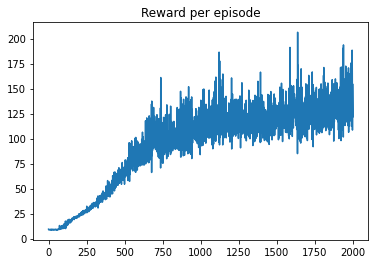

Episode reward: 222.0


In [14]:
BATCH_SIZE = 64

# repeat until convergence
env = gym.make("CartPole-v1")
model = Model(env)
reward_per_episode = []

for it in range(2000):

  # Some lists np.zeros(T)for batch GD
  G_store = []
  Values_store = []
  g_store = []
  episode_batch = []

  for batch in range(BATCH_SIZE): # A single batch
    # Collect states, rewards and actions for a single episode 
    states, rewards, actions = play_one_episode(env, model) 
    # print(states)
    # print(rewards)
    # print(actions)

    G = 0
    T = len(states)
    episode_reward = 0

    for  t in range(T-2, -1, -1):
      s = states[t]
      r = rewards[t+1]
      a = actions[t]
      G = r + GAMMA*G # Smart Update rule 

      # accumulate reward
      episode_reward += r

    # Accumulate G and Values for single episode for BGD
    G_store.append(G)
    Values_store.append(model.predict(s,a))
    g_store.append(model.grad(s,a))
    episode_batch.append(episode_reward)


  # print(np.array(G_store).shape)
  # print(np.array(Values_store).shape)
  # print(np.array(g_store).shape)
  # print(len(episode_batch))
  # print(len(G_store))
  # print(len(Values_store))
  # print(len(g_store))


  # Let's update Q(s,a) using approximate function
  # update the model
  model.w += ALPHA * np.dot((np.array(G_store) - np.array(Values_store)), np.array(g_store)) * 2/BATCH_SIZE
  
  # print(model.w.shape)

  if (it + 1) % 50 == 0:
    print(f"Episode: {it + 1}, Reward: {np.mean(episode_batch)}")

  # early exit
  if it > 20 and np.mean(reward_per_episode[-20:]) == 200:
    print("Early exit")
    break
  
  reward_per_episode.append(np.mean(episode_batch))

# test trained agent
test_reward = test_agent(model, env)
print(f"Average test reward: {test_reward}")

plt.plot(reward_per_episode)
plt.title("Reward per episode")
plt.show()

# watch trained agent
# env = gym.make("CartPole-v1", render_mode="human")
watch_agent(model, env, eps=0)

Some checks..

In [15]:
print(np.array(g_store).shape, np.array(Values_store).shape, np.array(G_store).shape)

(64, 100) (64,) (64,)


Conclusion: While batch gradient descent with MonteCarlo RL is possible, it isn't advisable because in RL, the policy is being updated and learnt based on the current Q-value estimation. So it is more rfficient to update the policy as soon as possible rather than wait till the end of a batch before the policy is updated, it will require longer training time to get best policies compared to Q-learning and single episode monte-Carlo methods.

Also, Q-learning is preferred to MonteCarlo method because the Q-values and policies get updated at the end of each timestep rather than wait till the end of the entire episode. And In the case of function approximation, where the ground truth (true return) itself has to be learnt and updated through experience, it is better to update the Q-values as soon as possible.

Finally, we can observe the reward recieved by the agent per batch increasing with the number of iterations.